# MK_resnet_152 model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 8

## Looking at the data

In [4]:
path = Path('./data/MK/D1')

In [5]:
path.ls()

[WindowsPath('data/MK/D1/Class10_1.jpg'),
 WindowsPath('data/MK/D1/Class10_10.jpg'),
 WindowsPath('data/MK/D1/Class10_11.jpg'),
 WindowsPath('data/MK/D1/Class10_12.jpg'),
 WindowsPath('data/MK/D1/Class10_13.jpg'),
 WindowsPath('data/MK/D1/Class10_14.jpg'),
 WindowsPath('data/MK/D1/Class10_15.jpg'),
 WindowsPath('data/MK/D1/Class10_16.jpg'),
 WindowsPath('data/MK/D1/Class10_17.jpg'),
 WindowsPath('data/MK/D1/Class10_18.jpg'),
 WindowsPath('data/MK/D1/Class10_19.jpg'),
 WindowsPath('data/MK/D1/Class10_2.jpg'),
 WindowsPath('data/MK/D1/Class10_20.jpg'),
 WindowsPath('data/MK/D1/Class10_21.jpg'),
 WindowsPath('data/MK/D1/Class10_22.jpg'),
 WindowsPath('data/MK/D1/Class10_23.jpg'),
 WindowsPath('data/MK/D1/Class10_24.jpg'),
 WindowsPath('data/MK/D1/Class10_25.jpg'),
 WindowsPath('data/MK/D1/Class10_26.jpg'),
 WindowsPath('data/MK/D1/Class10_27.jpg'),
 WindowsPath('data/MK/D1/Class10_28.jpg'),
 WindowsPath('data/MK/D1/Class10_29.jpg'),
 WindowsPath('data/MK/D1/Class10_3.jpg'),
 WindowsPath('

In [6]:
path_img = path

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('data/MK/D1/Class10_1.jpg'),
 WindowsPath('data/MK/D1/Class10_10.jpg'),
 WindowsPath('data/MK/D1/Class10_11.jpg'),
 WindowsPath('data/MK/D1/Class10_12.jpg'),
 WindowsPath('data/MK/D1/Class10_13.jpg')]

In [8]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [9]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

In [10]:
print(data.classes)
len(data.classes),data.c

['Class1', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14', 'Class15', 'Class16', 'Class17', 'Class18', 'Class19', 'Class2', 'Class20', 'Class21', 'Class22', 'Class23', 'Class24', 'Class25', 'Class26', 'Class27', 'Class28', 'Class29', 'Class3', 'Class30', 'Class31', 'Class32', 'Class33', 'Class34', 'Class35', 'Class36', 'Class37', 'Class38', 'Class39', 'Class4', 'Class40', 'Class41', 'Class42', 'Class43', 'Class44', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9']


(44, 44)

## Training

In [11]:
learn = cnn_learner(data, models.resnet152, metrics=error_rate)

In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [13]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.024429,1.143791,0.291297,03:38
1,1.170798,0.599412,0.184725,03:40
2,0.853299,0.473252,0.129663,03:42
3,0.696942,0.283124,0.094139,03:44
4,0.592995,0.227446,0.076377,03:42
5,0.471574,0.124189,0.035524,03:36
6,0.314959,0.098659,0.037300,03:40
7,0.238416,0.103190,0.030195,03:43
8,0.159889,0.093915,0.028419,03:50
9,0.192368,0.109030,0.039076,03:49


In [14]:
learn.save('mk_resnet152_stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

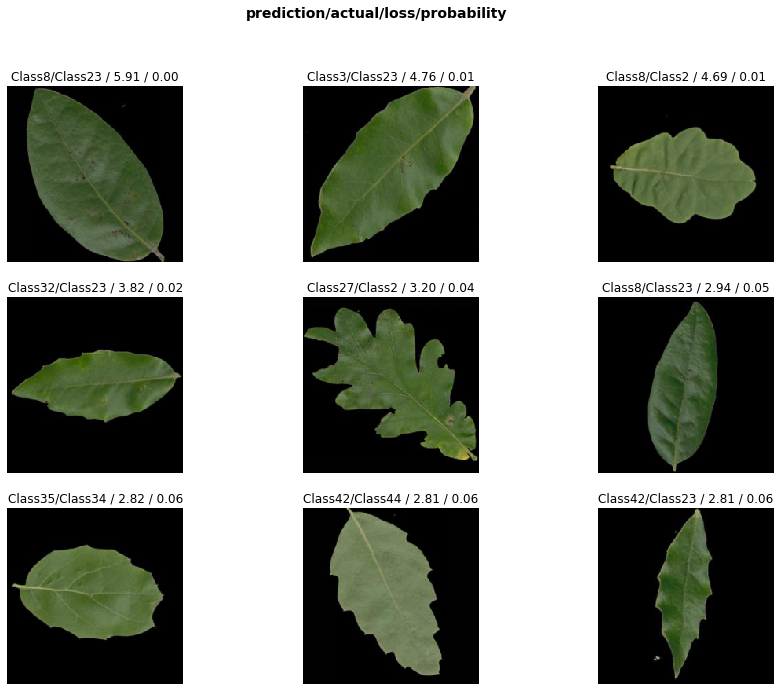

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

In [17]:
doc(interp.plot_top_losses)

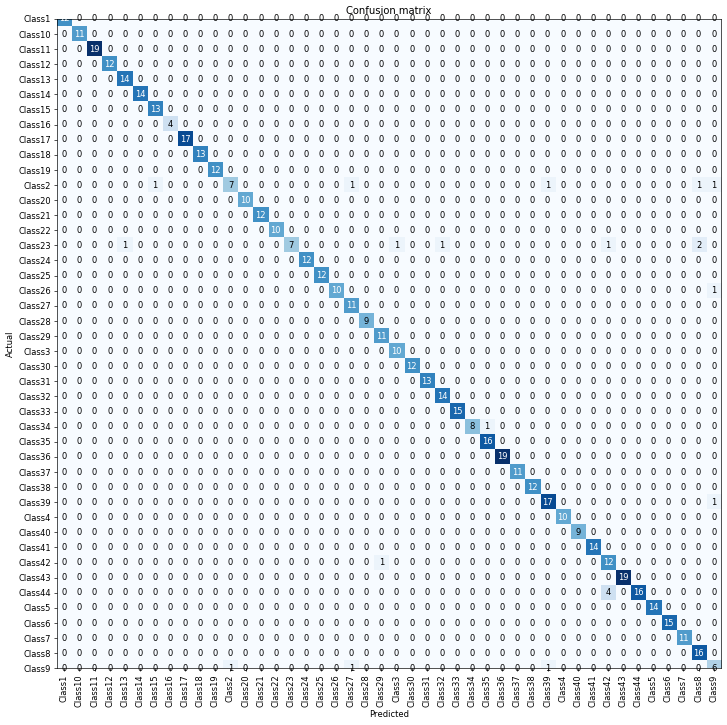

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [19]:
interp.most_confused(min_val=2)

[('Class44', 'Class42', 4), ('Class23', 'Class8', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [20]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.405219,0.486946,0.147425,05:00


In [22]:
learn.load('mk_resnet152_stage-1');

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


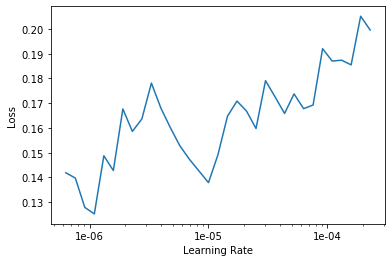

In [24]:
learn.recorder.plot()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 4.63 MiB (GPU 0; 4.00 GiB total capacity; 2.89 GiB already allocated; 1.85 MiB free; 43.82 MiB cached)

That's a pretty accurate model!